In [1]:
import sys
sys.path.insert(0, '../.')
import numpy as np
import math
from data.data_utils.reader_utils import read_calib
import tensorflow as tf
from data.detection_dataset_loader import *
from data.data_utils.data_reader import *
from data.data_utils.reader_utils import *
from model import *
from data.postprocessing.nms import *

/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-

In [2]:
import matplotlib.pyplot as plt

In [3]:
def read_label2(calib_reader, label_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
#     print(len(lines))
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = calib_reader.read_calib()

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])

    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print(len(locations))
    # print(z_range)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#         if angles[i] < 0:
#             angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions
    else:
        return output, indxes


In [4]:
def nms2(label, scores, max_output_size=100, iou_threshold=0.1, sess=None):
    boxes = []

    for j in range(0, len(label)):

        w = label[j][3]
        h = label[j][4] 
        x = label[j][0]
        y = label[j][1]
        a = label[j][6]
        

        polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
        xs = polygon[0::2]
        ys = polygon[1::2]
            
        boxes.append([xs[0], ys[0], xs[2], ys[2]])

    boxes = np.array(boxes)
    with tf.Graph().as_default():
        selected_indices = tf.image.non_max_suppression(
                    boxes, scores, max_output_size=max_output_size, iou_threshold=iou_threshold)
        if sess is not None:
            selected_indices = sess.run(selected_indices)
        else:
            with tf.Session() as sess:
                selected_indices = sess.run(selected_indices)

    return selected_indices



In [5]:

def cart2hom(pts_3d):
    ''' Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    '''
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom

def project_velo_to_ref(pts_3d_velo, Tr_velo_to_cam):
    pts_3d_velo = cart2hom(pts_3d_velo) # nx4
    return np.dot(pts_3d_velo, np.transpose(Tr_velo_to_cam))

    
def project_ref_to_rect(pts_3d_ref, R0_rect):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(R0_rect, np.transpose(pts_3d_ref)))

def ProjectTo2Dbbox(center, h, w, l, r_y, P2):
    # input: 3Dbbox in (rectified) camera coords

    Rmat = np.asarray([[math.cos(r_y), 0, math.sin(r_y)],
                       [0, 1, 0],
                       [-math.sin(r_y), 0, math.cos(r_y)]],
                       dtype='float32')

    p0 = center + np.dot(Rmat, np.asarray([l/2.0, 0, w/2.0], dtype='float32').flatten())
    p1 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, w/2.0], dtype='float32').flatten())
    p2 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p3 = center + np.dot(Rmat, np.asarray([l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p4 = center + np.dot(Rmat, np.asarray([l/2.0, -h, w/2.0], dtype='float32').flatten())
    p5 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, w/2.0], dtype='float32').flatten())
    p6 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, -w/2.0], dtype='float32').flatten())
    p7 = center + np.dot(Rmat, np.asarray([l/2.0, -h, -w/2.0], dtype='float32').flatten())

    points = np.array([p0, p1, p2, p3, p4, p5, p6, p7])

    points_hom = np.ones((points.shape[0], 4)) # (shape: (8, 4))
    points_hom[:, 0:3] = points

    # project the points onto the image plane (homogeneous coords):
    img_points_hom = np.dot(P2, points_hom.T).T # (shape: (8, 3)) (points_hom.T has shape (4, 8))
    # normalize:
    img_points = np.zeros((img_points_hom.shape[0], 2)) # (shape: (8, 2))
    img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
    img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

    u_min = np.min(img_points[:, 0])
    v_min = np.min(img_points[:, 1])
    u_max = np.max(img_points[:, 0])
    v_max = np.max(img_points[:, 1])

    left = int(u_min)
    top = int(v_min)
    right = int(u_max)
    bottom = int(v_max)

    projected_2Dbbox = [left, top, right, bottom]

    return projected_2Dbbox


def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x


def convert_prediction_into_real_values2(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
#             print('x = ', x, "y = ", y)
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x, y, 0., anchors[0], anchors[1], anchors[2]])

#             mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
#             maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
#             out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
#             out[:2] = out[:2][::-1]
#             if truth_value is not None:
#                 print('gt = ', truth_value[ones_index[0][i], ones_index[1][i], :3])
            print('out[:3] = ', out[:3])
            out[:6] = np.exp(out[:6])
            print('exp(out[:3]) = ', out[:3])
    
            out[:3] = out[:3] + anchor[:3] - 1
            print('out[:3] anch = ', out[:3])
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
            print('final out[:3] = ', out[:3])
            
            
            
            out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x+0.5, y+0.5, 1., anchors[0], anchors[1], anchors[2]])

            mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
            maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
            out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
            
            out[:2] = out[:2] + anchor[:2]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
            out[3:6] = np.exp(out[3:6])
            
            out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)


def get_points(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(448, 512, 35), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            
            calib_reader = CalibReader(calib_path)
            calib_data = calib_reader.read_calib()

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result


def prepare_dataset_feed_dict(model, dataset, train_fusion_rgb):
        data = dataset.get_next(batch_size=1)
        camera_tensor, lidar_tensor, label_tensor= data
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False,
                model.weight_cls: 1,
                model.weight_dim: 1,
                model.weight_loc: 1,
                model.weight_theta: 1}
        return d



In [6]:

def write_predictions(labels_output, calib_path, new_file_path, th=0.5, truth_value=None, is_label=False, base_path = '../../../Data'):
    converted_points = convert_prediction_into_real_values2(labels_output, truth_value=truth_value, th=th, is_label=is_label)
#     print(len(converted_points))
    points = get_points(converted_points, calib_path, th=th)
#     print(len(points))
#     print('---')
    res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

def write_all_predictions(model, dir_name, training, augment=False, get_best=False, fusion=False, base_path = '../../../Data'):
    with model.graph.as_default():
            
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        with tf.Session(config=config) as sess:
            if get_best:
                model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp_best2/'))
            else:
                model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
                

            dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training, augment=augment)
        
            cls_losses = []
            reg_losses = []
            total_losses = []
            i = 0
            
            apply_nms=False

            if training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(base_path + file_name, 'r') as f:
                            list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]
            list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            try:    
                while True:
                    feed_dict = prepare_dataset_feed_dict(model, dataset, fusion)
                    final_output= sess.run(model.final_output, feed_dict=feed_dict)
#                     print(i, np.where(sigmoid(final_output[0][:, :, :, -1])>=0.2))
                    if i < len(list_files):
                        current_file = list_files[i]

                        for th, th_str in zip([0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ['05', '10', '20', '30', '40', '50']):
                            new_file_path = '../prediction_files/' + dir_name + '/bev/th' + th_str + '_2/data/' + current_file + '.txt'
                            write_predictions(final_output[0], list_calib_paths[i], new_file_path, th=th)
#                         th, th_str = 0.1, '10'
#                         new_file_path = '../prediction_files/' + dir_name + '/bev/th' + th_str + '_2/data/' + current_file + '.txt'
#                         write_predictions(final_output[0], list_calib_paths[i], new_file_path, th=th)
                                
                    else:
                        break
                        
#                     if i == 2:
#                         return
#                     print('--------')

                    i += 1
                    if i % 100 == 0:
                        print('i = ', i)
            except tf.errors.OutOfRangeError:
                pass
            except StopIteration:
                pass
            finally:
                print('Done')

In [7]:
def write_predictions_nms(th, new_file_path, old_file_path, calib_reader, base_path = '../../../Data'):
    
    res = []
    with open(old_file_path) as label_file:
            res = label_file.readlines()
    res = ''.join(res)
    points2 = res.split('\n')
    points = []
    for i in range(len(points2)):
        temp = []
        temp = points2[i].split(' ')
        points.append(temp)
#     print('here')
    labels, indxes = read_label2(calib_reader, res, 0, 0, get_actual_dims=True, from_file=False)

    points = np.array(points)
#     print('here')
    if len(labels) > 0:
        points = points[indxes]
        selected_idx = nms2(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
    else:
        selected_idx = []

    if len(selected_idx) > 0:
        points = points[selected_idx]
        res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
    else:
        res=""
    
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

def get_augmentation_parameters():
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    return rot, tr, sc, image_translate_x, image_translate_y, ang
    
def write_all_predictions_nms(old_dir, training, base_path = '../../../Data'):
    i = 0       
    try:    
        while True:
            
            if training:
                file_name = '/trainsplit.txt'
            else:
                            file_name = '/valsplit.txt'
            with open(base_path + file_name, 'r') as f:
                            list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

            list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
            list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
            list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
            list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            rot, tr, sc, image_translate_x, image_translate_y, ang = get_augmentation_parameters()
            
            if i < len(list_files):
                current_file = list_files[i]
                data_reader_obj = DataReader(list_camera_paths[i],
                             list_calib_paths[i], 
                             list_label_paths[i], 
                             list_lidar_paths[i], 
                            rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=True)
            
                for th, th_str in zip([0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ['05', '10', '20', '30', '40', '50']):
                    old_file_path = '../prediction_files/' + old_dir + '/bev/th' + th_str + '_2/data/' + current_file + '.txt'
                    new_file_path = '../prediction_files/' + old_dir + '/nms/th' + th_str + '_2/data/' + current_file + '.txt'
                    write_predictions_nms(th, new_file_path, old_file_path, data_reader_obj.calib_reader)
      
            else:
                break
            i += 1
            if i % 100 == 0:
                print('i = ', i)
    except tf.errors.OutOfRangeError as e:
        print("i at break1 = ", i)
    except StopIteration as e:
        print("i at break2 = ", i)
    except Exception as e:
        print("i at break3 = ", i, e)

In [8]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)

/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [9]:
dir_name = 'test_no_fusion_4'

In [10]:
# !rm -r "../prediction_files/train_no_fusion_3"

In [11]:
# !mkdir "../prediction_files"
!mkdir "../prediction_files/""$dir_name"
!mkdir "../prediction_files/""$dir_name""/bev/"
!mkdir "../prediction_files/""$dir_name""/bev/th05_2"
!mkdir "../prediction_files/""$dir_name""/bev/th05_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/"
!mkdir "../prediction_files/""$dir_name""/nms/th05_2"
!mkdir "../prediction_files/""$dir_name""/nms/th05_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th10_2"
!mkdir "../prediction_files/""$dir_name""/nms/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th20_2"
!mkdir "../prediction_files/""$dir_name""/nms/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th30_2"
!mkdir "../prediction_files/""$dir_name""/nms/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th40_2"
!mkdir "../prediction_files/""$dir_name""/nms/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th50_2"
!mkdir "../prediction_files/""$dir_name""/nms/th50_2/data"

mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th05_2’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th05_2/data’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th10_2’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th10_2/data’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th20_2’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th20_2/data’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th30_2’: File exists
mkdir: cannot create directory ‘../prediction_files/test_no_fusion_4/bev/th30_2/data’: File exists
mkdir: cannot create directory ‘../prediction_files/test_

In [ ]:
write_all_predictions(model, dir_name, training=True, augment=False, get_best=False, fusion=False)

In [ ]:
write_all_predictions_nms(dir_name, training=True)

In [12]:
write_all_predictions(model, dir_name, training=False, augment=False, get_best=True, fusion=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp_best2/model.ckpt-38661
out[:3] =  [0.40404028 0.4195571  0.5771352 ]
exp(out[:3]) =  [1.4978642 1.5212876 1.7809291]
out[:3] anch =  [29.497864  63.521286   0.7809291]
final out[:3] =  [117.991455 254.08514   27.332518]
out[:3] =  [0.421941   0.38704383 0.5834688 ]
exp(out[:3]) =  [1.5249186 1.4726211 1.7922446]
out[:3] anch =  [30.524918   63.472622    0.79224455]
final out[:3] =  [122.09967 253.89049  27.72856]
out[:3] =  [0.31255245 0.54445547 0.5547528 ]
exp(out[:3]) =  [1.3669096 1.7236695 1.7415105]
out[:3] anch =  [31.366909  62.72367    0.7415105]
final out[:3] =  [125.467636 250.89468   25.952868]
out[:3] =  [0.29923266 0.40232247 0.555589  ]
exp(out[:3]) =  [1.3488234 1.4952935 1.7429674]
out[:3] anch =  [31.348824   63.495293    0.74296737]
final out[:3] =  [125.395294 253.98117   26.003859]
out[:3] =  [0.32521936 0.4339133  0.5572032 ]
exp(out[:3]) =  [1.3843343 1.543285  1.745783 ]
out[:3] anch =  [62.384335 6

out[:3] =  [0.5179683  0.45084447 0.48160338]
exp(out[:3]) =  [1.6786138 1.5696372 1.6186677]
out[:3] anch =  [ 1.6786138 62.569637   0.6186677]
final out[:3] =  [  6.714455 250.27855   21.65337 ]
out[:3] =  [0.41635475 0.50168544 0.49149382]
exp(out[:3]) =  [1.5164237 1.6515025 1.6347564]
out[:3] anch =  [ 3.5164237  71.651505    0.63475645]
final out[:3] =  [ 14.065695 286.60602   22.216476]
out[:3] =  [0.38404852 0.5726904  0.51622254]
exp(out[:3]) =  [1.4682167 1.7730309 1.6756859]
out[:3] anch =  [ 4.468217  71.77303    0.6756859]
final out[:3] =  [ 17.872868 287.09213   23.649006]
out[:3] =  [0.31435928 0.46869534 0.49476653]
exp(out[:3]) =  [1.3693817 1.5979081 1.6401153]
out[:3] anch =  [ 7.369382   63.597908    0.64011526]
final out[:3] =  [ 29.477528 254.39163   22.404034]
out[:3] =  [0.46037072 0.502748   0.36841494]
exp(out[:3]) =  [1.5846614 1.6532582 1.4454417]
out[:3] anch =  [  9.5846615  111.65326      0.44544172]
final out[:3] =  [ 38.338646 446.61304   15.59046 ]
out

out[:3] =  [0.24535218 0.61781836 0.5188614 ]
exp(out[:3]) =  [1.2780713 1.854877  1.6801136]
out[:3] anch =  [61.278072   59.854877    0.68011355]
final out[:3] =  [245.11229  239.41951   23.803974]
out[:3] =  [0.36958525 0.52077425 0.5391345 ]
exp(out[:3]) =  [1.4471343 1.6833304 1.7145224]
out[:3] anch =  [80.447136   43.68333     0.71452236]
final out[:3] =  [321.78854  174.73332   25.008282]
out[:3] =  [0.54957545 0.5166293  0.5916997 ]
exp(out[:3]) =  [1.7325174 1.6763675 1.8070573]
out[:3] anch =  [22.732517   95.67637     0.80705726]
final out[:3] =  [ 90.93007  382.70547   28.247004]
out[:3] =  [0.55877924 0.24182293 0.5693724 ]
exp(out[:3]) =  [1.7485367 1.2735686 1.7671577]
out[:3] anch =  [22.748537  96.27357    0.7671577]
final out[:3] =  [ 90.99415 385.09427  26.85052]
out[:3] =  [0.4961911  0.57763094 0.57913774]
exp(out[:3]) =  [1.6424534 1.7818122 1.784499 ]
out[:3] anch =  [23.642454   95.781815    0.78449905]
final out[:3] =  [ 94.56982  383.12726   27.457466]
out[:3

out[:3] =  [0.35562733 0.30536956 0.4485647 ]
exp(out[:3]) =  [1.4270756 1.3571265 1.5660628]
out[:3] anch =  [  4.4270754 107.357124    0.5660628]
final out[:3] =  [ 17.708302 429.4285    19.812199]
out[:3] =  [0.4493415  0.43008393 0.5047357 ]
exp(out[:3]) =  [1.5672798 1.5373865 1.6565477]
out[:3] anch =  [  5.56728    106.537384     0.65654767]
final out[:3] =  [ 22.26912  426.14954   22.979168]
out[:3] =  [0.38619563 0.25782323 0.5663737 ]
exp(out[:3]) =  [1.4713725 1.2941101 1.7618665]
out[:3] anch =  [ 9.471373   29.29411     0.76186645]
final out[:3] =  [ 37.88549  117.17644   26.665325]
out[:3] =  [0.3193342  0.4415422  0.56263775]
exp(out[:3]) =  [1.3762112 1.5551037 1.7552965]
out[:3] anch =  [ 9.376211   53.555103    0.75529647]
final out[:3] =  [ 37.504845 214.22041   26.435377]
out[:3] =  [0.5167073  0.24364991 0.6078083 ]
exp(out[:3]) =  [1.6764983 1.2758976 1.8364022]
out[:3] anch =  [15.676498   3.2758975  0.8364022]
final out[:3] =  [62.705994 13.10359  29.274076]
out

out[:3] =  [0.16722704 0.3455978  0.57750386]
exp(out[:3]) =  [1.1820226 1.4128343 1.7815858]
out[:3] anch =  [104.18202    71.412834    0.7815858]
final out[:3] =  [416.7281   285.65134   27.355503]
out[:3] =  [0.48082322 0.52316606 0.51571393]
exp(out[:3]) =  [1.6174053 1.6873615 1.6748338]
out[:3] anch =  [27.617405  81.68736    0.6748338]
final out[:3] =  [110.46962  326.74945   23.619183]
out[:3] =  [0.53401375 0.24534975 0.5147782 ]
exp(out[:3]) =  [1.7057651 1.2780682 1.6732674]
out[:3] anch =  [27.705765   82.27807     0.67326736]
final out[:3] =  [110.82306  329.11227   23.564358]
out[:3] =  [0.1744775 0.3307594 0.5228715]
exp(out[:3]) =  [1.190624  1.3920249 1.6868645]
out[:3] anch =  [28.190624  82.39202    0.6868645]
final out[:3] =  [112.7625   329.56808   24.040257]
out[:3] =  [0.5898913  0.4372177  0.55136853]
exp(out[:3]) =  [1.8037924 1.5483931 1.7356267]
out[:3] anch =  [41.80379   70.54839    0.7356267]
final out[:3] =  [167.21516  282.19357   25.746935]
out[:3] =  [

out[:3] =  [0.47764733 0.36360842 0.58335453]
exp(out[:3]) =  [1.6122768 1.4385108 1.7920399]
out[:3] anch =  [ 2.6122768 65.43851    0.7920399]
final out[:3] =  [ 10.449107 261.75403   27.721395]
out[:3] =  [0.49443594 0.4369703  0.59775037]
exp(out[:3]) =  [1.6395731 1.5480101 1.8180243]
out[:3] anch =  [ 3.639573  53.54801    0.8180243]
final out[:3] =  [ 14.558292 214.19205   28.63085 ]
out[:3] =  [0.30016437 0.4643569  0.57757   ]
exp(out[:3]) =  [1.3500807 1.5909907 1.7817037]
out[:3] anch =  [ 3.3500807 64.59099    0.7817037]
final out[:3] =  [ 13.400323 258.36395   27.35963 ]
out[:3] =  [0.3048175 0.3606488 0.5756472]
exp(out[:3]) =  [1.3563775 1.4342597 1.778281 ]
out[:3] anch =  [ 3.3563776 68.43426    0.778281 ]
final out[:3] =  [ 13.42551  273.73703   27.239834]
out[:3] =  [0.38745624 0.4615113  0.59157   ]
exp(out[:3]) =  [1.4732285 1.5864698 1.8068229]
out[:3] anch =  [ 4.4732285 53.58647    0.8068229]
final out[:3] =  [ 17.892914 214.34589   28.238802]
out[:3] =  [0.4116

out[:3] =  [0.5905708  0.4746096  0.65013915]
exp(out[:3]) =  [1.8050184 1.6073866 1.9158074]
out[:3] anch =  [46.80502    82.60738     0.91580737]
final out[:3] =  [187.22008  330.42953   32.053257]
out[:3] =  [0.4628424  0.45183116 0.6280784 ]
exp(out[:3]) =  [1.588583  1.5711867 1.874006 ]
out[:3] anch =  [47.588585   77.57119     0.87400603]
final out[:3] =  [190.35434  310.28476   30.590212]
out[:3] =  [0.45506662 0.39808416 0.65443224]
exp(out[:3]) =  [1.5762784 1.4889693 1.9240499]
out[:3] anch =  [47.57628    78.48897     0.92404985]
final out[:3] =  [190.30511  313.95587   32.341743]
out[:3] =  [0.46221176 0.45164776 0.67786735]
exp(out[:3]) =  [1.5875814 1.5708985 1.9696727]
out[:3] anch =  [47.58758   79.5709     0.9696727]
final out[:3] =  [190.35033  318.2836    33.938545]
out[:3] =  [0.41717693 0.484093   0.6920364 ]
exp(out[:3]) =  [1.517671  1.6227026 1.9977796]
out[:3] anch =  [47.51767   80.6227     0.9977796]
final out[:3] =  [190.07068  322.4908    34.922287]
out[:3

out[:3] =  [0.5275103  0.4307688  0.47913224]
exp(out[:3]) =  [1.6947078 1.5384398 1.6146727]
out[:3] anch =  [ 5.694708   65.53844     0.61467266]
final out[:3] =  [ 22.778831 262.15375   21.513542]
out[:3] =  [0.37984273 0.43387645 0.49587756]
exp(out[:3]) =  [1.4620546 1.5432281 1.6419386]
out[:3] anch =  [ 6.4620547  65.54323     0.64193857]
final out[:3] =  [ 25.848219 262.1729    22.46785 ]
out[:3] =  [0.4140806  0.25543118 0.49606425]
exp(out[:3]) =  [1.512979  1.2910181 1.642245 ]
out[:3] anch =  [ 6.512979   66.291016    0.64224505]
final out[:3] =  [ 26.051916 265.16406   22.478577]
out[:3] =  [0.36829448 0.45768535 0.5283491 ]
exp(out[:3]) =  [1.4452676 1.5804117 1.6961298]
out[:3] anch =  [ 7.4452677 65.580414   0.6961298]
final out[:3] =  [ 29.78107  262.32166   24.364544]
out[:3] =  [0.48240772 0.53342754 0.51133066]
exp(out[:3]) =  [1.6199702 1.7047654 1.6675086]
out[:3] anch =  [ 8.61997   76.704765   0.6675086]
final out[:3] =  [ 34.47988 306.81906  23.3628 ]
out[:3] =

out[:3] =  [0.4719076  0.41831005 0.5786337 ]
exp(out[:3]) =  [1.6030493 1.5193917 1.7835999]
out[:3] anch =  [ 3.6030493  45.51939     0.78359985]
final out[:3] =  [ 14.412197 182.07756   27.425995]
out[:3] =  [0.5218718  0.41638422 0.6389125 ]
exp(out[:3]) =  [1.685179  1.5164684 1.8944196]
out[:3] anch =  [24.685179   56.516468    0.89441955]
final out[:3] =  [ 98.740715 226.06587   31.304684]
out[:3] =  [0.51673216 0.35313177 0.62863576]
exp(out[:3]) =  [1.67654   1.4235187 1.8750508]
out[:3] anch =  [24.67654   57.42352    0.8750508]
final out[:3] =  [ 98.70616  229.69408   30.626778]
out[:3] =  [0.39962402 0.423055   0.6551447 ]
exp(out[:3]) =  [1.4912639 1.5266182 1.9254211]
out[:3] anch =  [25.491264  56.52662    0.9254211]
final out[:3] =  [101.96506 226.10648  32.38974]
out[:3] =  [0.43290266 0.40163022 0.6540315 ]
exp(out[:3]) =  [1.5417261 1.4942586 1.9232789]
out[:3] anch =  [25.541725  57.49426    0.9232789]
final out[:3] =  [102.1669   229.97704   32.314762]
out[:3] =  [

out[:3] =  [0.38772842 0.37827265 0.60905683]
exp(out[:3]) =  [1.4736295 1.4597609 1.8386964]
out[:3] anch =  [13.473629   68.45976     0.83869636]
final out[:3] =  [ 53.894516 273.83905   29.354372]
out[:3] =  [0.5894642  0.49944627 0.5838628 ]
exp(out[:3]) =  [1.803022  1.6478086 1.7929509]
out[:3] anch =  [23.803022   74.64781     0.79295087]
final out[:3] =  [ 95.21209 298.59125  27.75328]
out[:3] =  [0.56181824 0.10082476 0.5872041 ]
exp(out[:3]) =  [1.7538586 1.1060828 1.7989517]
out[:3] anch =  [23.753859   75.10608     0.79895175]
final out[:3] =  [ 95.015434 300.42432   27.96331 ]
out[:3] =  [0.3853574  0.45619172 0.60629517]
exp(out[:3]) =  [1.4701396 1.5780529 1.8336256]
out[:3] anch =  [24.47014    73.57806     0.83362556]
final out[:3] =  [ 97.88056  294.31223   29.176895]
out[:3] =  [0.33129728 0.5229822  0.5883029 ]
exp(out[:3]) =  [1.3927737 1.6870513 1.8009294]
out[:3] anch =  [24.392775  74.68705    0.8009294]
final out[:3] =  [ 97.5711  298.7482   28.03253]
out[:3] =

out[:3] =  [0.49836084 0.4959181  0.5179783 ]
exp(out[:3]) =  [1.646021  1.6420051 1.6786306]
out[:3] anch =  [ 1.646021  57.642006   0.6786306]
final out[:3] =  [  6.584084 230.56802   23.752071]
out[:3] =  [0.49704748 0.26545322 0.5237442 ]
exp(out[:3]) =  [1.6438606 1.3040218 1.6883373]
out[:3] anch =  [ 1.6438606 61.304024   0.6883373]
final out[:3] =  [  6.5754423 245.2161     24.091806 ]
out[:3] =  [0.34837505 0.5067771  0.49425554]
exp(out[:3]) =  [1.4167635 1.6599327 1.6392775]
out[:3] anch =  [ 2.4167635  57.65993     0.63927746]
final out[:3] =  [  9.667054 230.63972   22.37471 ]
out[:3] =  [0.5164385  0.6098337  0.53854734]
exp(out[:3]) =  [1.6760477 1.8401254 1.7135159]
out[:3] anch =  [ 2.6760478 60.840126   0.7135159]
final out[:3] =  [ 10.704191 243.3605    24.973055]
out[:3] =  [0.50281924 0.19729948 0.5424189 ]
exp(out[:3]) =  [1.653376  1.2181088 1.7201627]
out[:3] anch =  [ 2.653376   61.21811     0.72016275]
final out[:3] =  [ 10.613504 244.87244   25.205696]
out[:3

out[:3] =  [0.528689   0.18194053 0.52180785]
exp(out[:3]) =  [1.6967065 1.1995429 1.6850712]
out[:3] anch =  [44.696705   61.199543    0.68507123]
final out[:3] =  [178.78682  244.79817   23.977493]
out[:3] =  [0.39850613 0.5010918  0.5640689 ]
exp(out[:3]) =  [1.4895978 1.6505224 1.7578104]
out[:3] anch =  [45.489597   60.650524    0.75781035]
final out[:3] =  [181.95839  242.6021    26.523363]
out[:3] =  [0.33969665 0.1941474  0.5268503 ]
exp(out[:3]) =  [1.4045215 1.2142752 1.6935896]
out[:3] anch =  [45.404522   61.214275    0.69358957]
final out[:3] =  [181.61809  244.8571    24.275635]
out[:3] =  [0.46488228 0.3772406  0.5779935 ]
exp(out[:3]) =  [1.5918268 1.4582552 1.7824583]
out[:3] anch =  [111.59183    60.458256    0.7824583]
final out[:3] =  [446.3673  241.83302  27.38604]
out[:3] =  [0.39850613 0.5010918  0.5640689 ]
exp(out[:3]) =  [1.4895978 1.6505224 1.7578104]
out[:3] anch =  [45.489597   60.650524    0.75781035]
final out[:3] =  [181.95839  242.6021    26.523363]
out

out[:3] =  [0.5446861  0.31102622 0.49559164]
exp(out[:3]) =  [1.7240671 1.364825  1.6414691]
out[:3] anch =  [12.724067  76.36482    0.6414691]
final out[:3] =  [ 50.896267 305.4593    22.45142 ]
out[:3] =  [0.44343808 0.42231852 0.49539477]
exp(out[:3]) =  [1.5580547 1.5254943 1.641146 ]
out[:3] anch =  [13.558055   76.5255      0.64114594]
final out[:3] =  [ 54.23222  306.102     22.440107]
out[:3] =  [0.51852804 0.2598701  0.4903553 ]
exp(out[:3]) =  [1.6795536 1.2967616 1.6328963]
out[:3] anch =  [13.679554  77.29676    0.6328963]
final out[:3] =  [ 54.718216 309.18704   22.151371]
out[:3] =  [0.3153288  0.35304964 0.4921273 ]
exp(out[:3]) =  [1.3707099 1.4234018 1.6357924]
out[:3] anch =  [14.37071   77.4234     0.6357924]
final out[:3] =  [ 57.48284  309.6936    22.252733]
out[:3] =  [0.5008033  0.366112   0.45795268]
exp(out[:3]) =  [1.6500462 1.4421167 1.5808342]
out[:3] anch =  [29.650045   37.442116    0.58083415]
final out[:3] =  [118.60018  149.76846   20.329195]
out[:3] =

out[:3] =  [0.3341615  0.518603   0.53675604]
exp(out[:3]) =  [1.3967687 1.6796795 1.7104492]
out[:3] anch =  [ 0.3967687 73.67968    0.7104492]
final out[:3] =  [  1.5870748 294.71872    24.865723 ]
out[:3] =  [0.32805297 0.38848418 0.5304756 ]
exp(out[:3]) =  [1.3882625 1.4747436 1.6997405]
out[:3] anch =  [ 0.3882625 74.47475    0.6997405]
final out[:3] =  [  1.55305 297.899    24.49092]
out[:3] =  [0.4405338  0.39470625 0.50619274]
exp(out[:3]) =  [1.5535363 1.4839482 1.6589631]
out[:3] anch =  [ 0.5535363 75.48395    0.6589631]
final out[:3] =  [  2.2141452 301.9358     23.063707 ]
out[:3] =  [0.35541412 0.45109951 0.41613084]
exp(out[:3]) =  [1.4267714 1.5700375 1.5160842]
out[:3] anch =  [ 1.4267714 41.570038   0.5160842]
final out[:3] =  [  5.7070856 166.28015    18.062946 ]
out[:3] =  [0.23667264 0.49189353 0.5050991 ]
exp(out[:3]) =  [1.2670263 1.63541   1.6571498]
out[:3] anch =  [ 1.2670263 74.63541    0.6571498]
final out[:3] =  [  5.068105 298.54163   23.000242]
out[:3] =

out[:3] =  [0.6884917  0.06723619 0.54096085]
exp(out[:3]) =  [1.9907107 1.069548  1.7176565]
out[:3] anch =  [88.99071   52.06955    0.7176565]
final out[:3] =  [355.96283  208.2782    25.117977]
out[:3] =  [0.04091034 0.51437235 0.6118873 ]
exp(out[:3]) =  [1.0417587 1.6725883 1.8439081]
out[:3] anch =  [89.041756  51.67259    0.8439081]
final out[:3] =  [356.16702  206.69035   29.536783]
out[:3] =  [0.12678087 0.1569685  0.58536184]
exp(out[:3]) =  [1.1351682 1.1699587 1.7956406]
out[:3] anch =  [89.13517   52.16996    0.7956406]
final out[:3] =  [356.54068 208.67984  27.84742]
out[:3] =  [0.34913805 0.56133646 0.486234  ]
exp(out[:3]) =  [1.4178449 1.7530137 1.6261805]
out[:3] anch =  [ 9.417845  53.753014   0.6261805]
final out[:3] =  [ 37.67138  215.01205   21.916319]
out[:3] =  [0.36609015 0.15280446 0.49129492]
exp(out[:3]) =  [1.4420853 1.1650971 1.6344314]
out[:3] anch =  [ 9.442085   54.165096    0.63443136]
final out[:3] =  [ 37.76834  216.66039   22.205097]
out[:3] =  [0.3

KeyboardInterrupt: 

In [13]:
write_all_predictions_nms(dir_name, training=False)

i at break3 =  20 [Errno 2] No such file or directory: '../prediction_files/test_no_fusion_4/bev/th05_2/data/000039.txt'


In [35]:
def get_stats(model, training, augment=False, get_best=False, fusion=False, base_path = '../../../Data'):
    with model.graph.as_default():
            
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        with tf.Session(config=config) as sess:
#             if get_best:
#                 model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp_best2/'))
#             else:
#                 model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
                
            model.saver.restore(sess, '../training_files/tmp/model.ckpt-125188')

            dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training, augment=augment)
        
            cls_losses = []
            reg_losses = []
            total_losses = []
            i = 0
            
            apply_nms=False

            if training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(base_path + file_name, 'r') as f:
                            list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]
            list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            cls_losses = []
            dim_losses = []
            loc_losses = []
            theta_losses = []
            ious = []
            dim_ious = []
            loc_ious = []
            theta_diffs = []
            precisions = []
            recalls = []
            try:  
                c = 0
                while c < 200:
                    feed_dict = prepare_dataset_feed_dict(model, dataset, fusion)
                    
                    final_output, cls_loss, loc_loss, dim_loss, theta_loss,\
                        reg_loss, iou, iou_dim, iou_loc, precision, recall, theta_accuracy = sess.run([model.final_output,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                             model.regression_loss,\
                                                             model.iou, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall,\
                                                              model.theta_accuracy ],\
                                                             feed_dict=feed_dict) 
                    cls_losses.append(cls_loss)
                    dim_losses.append(dim_loss)
                    loc_losses.append(loc_loss)
                    theta_losses.append(theta_loss)
                    ious.append(iou)
                    dim_ious.append(iou_dim)
                    loc_ious.append(iou_loc)
                    theta_diffs.append(theta_accuracy)
                    precisions.append(precision)
                    recalls.append(recall)
                    c += 1
            except: 
                pass
                    
            return cls_losses, dim_losses, loc_losses, theta_losses, ious, dim_ious, loc_ious, theta_diffs, precisions, recalls
        

In [21]:
cls_losses, dim_losses, loc_losses, theta_losses,\
            ious, dim_ious, loc_ious, theta_diffs,\
            precisions, recalls = get_stats(model, training=True, get_best=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-287196


In [33]:
ious = np.array(ious)
np.where((ious < 0.5) & (ious > 0))

(array([ 42,  50, 141, 162, 178]),)

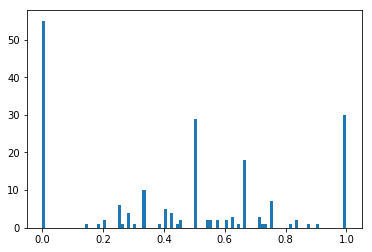

In [22]:
plt.hist(recalls, bins=100)
plt.show()

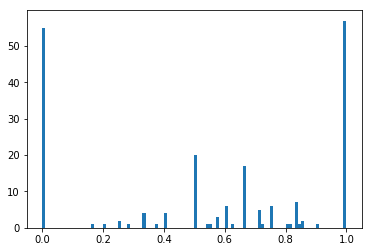

In [23]:
plt.hist(precisions, bins=100)
plt.show()

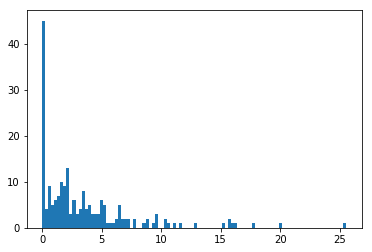

In [24]:
plt.hist(cls_losses, bins=100)
plt.show()

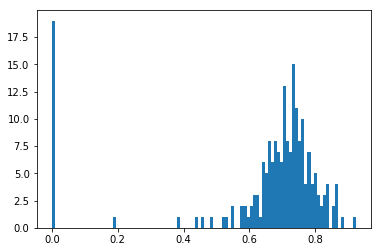

In [25]:
plt.hist(ious, bins=100)
plt.show()

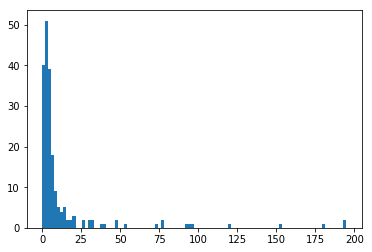

In [26]:
plt.hist(theta_diffs, bins=100)
plt.show()

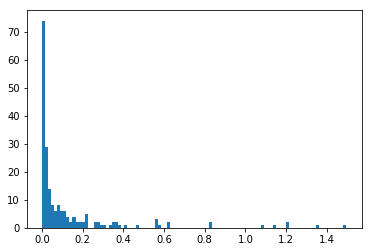

In [27]:
plt.hist(theta_losses, bins=100)
plt.show()

In [36]:
cls_losses_test, dim_losses_test, loc_losses_test, theta_losses_test,\
            ious_test, dim_ious_test, loc_ious_test, theta_diffs_test,\
            precisions_test, recalls_test = get_stats(model, training=False, get_best=True)

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-125188


In [43]:
ious_test

[0.0,
 0.43219683,
 0.745555,
 0.0,
 0.6602779,
 0.66935486,
 0.74854803,
 0.8861931,
 0.77676725,
 0.7312043,
 0.66946,
 0.6760372,
 0.62654716,
 0.5926412,
 0.0,
 0.58384365,
 0.8215821,
 0.76533306,
 0.71019,
 0.60522044,
 0.7435319,
 0.9009169,
 0.90507966,
 0.82133657,
 0.67270267,
 0.6804948,
 0.0,
 0.6582035,
 0.79586333,
 0.0,
 0.78797317,
 0.6930176,
 0.74146533,
 0.68471754,
 0.6901567,
 0.0,
 0.0,
 0.7729192,
 0.80922973,
 0.5963738,
 0.64263386,
 0.71475637,
 0.612792,
 0.6321238,
 0.84683746,
 0.7117473,
 0.6165764,
 0.750239,
 0.6271988,
 0.800263,
 0.6248838,
 0.0,
 0.73815876,
 0.0,
 0.5855968,
 0.5947856,
 0.6371158,
 0.6576049,
 0.7321892,
 0.6304323,
 0.7741113,
 0.7291346,
 0.65374476,
 0.71687603,
 0.0,
 0.7231232,
 0.6035422,
 0.71447444,
 0.7230201,
 0.60007995,
 0.0,
 0.71512413,
 0.63620216,
 0.6381933,
 0.62946385,
 0.78296715,
 0.7594386,
 0.8113456,
 0.7173376,
 0.7016406,
 0.7839985,
 0.7696762,
 0.76582843,
 0.0,
 0.7079873,
 0.0,
 0.0,
 0.8349761,
 0.0,
 

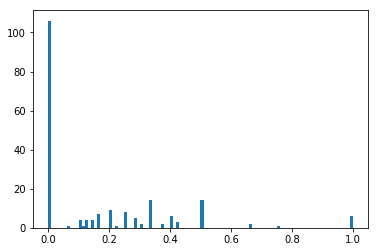

In [37]:
plt.hist(recalls_test, bins=100)
plt.show()

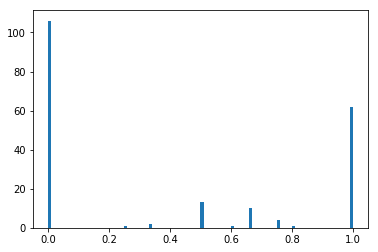

In [38]:
plt.hist(precisions_test, bins=100)
plt.show()

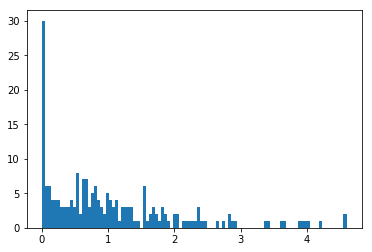

In [39]:
plt.hist(cls_losses_test, bins=100)
plt.show()

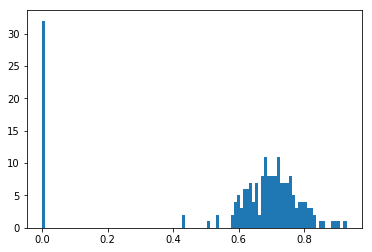

In [40]:
plt.hist(ious_test, bins=100)
plt.show()

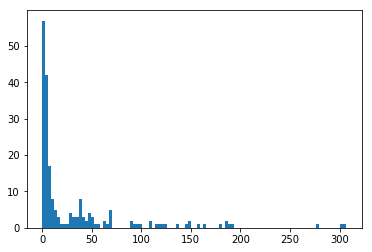

In [41]:
plt.hist(theta_diffs_test, bins=100)
plt.show()

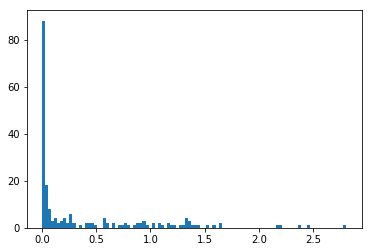

In [42]:
plt.hist(theta_losses_test, bins=100)
plt.show()

In [27]:
cls_losses_test2, dim_losses_test2, loc_losses_test2, theta_losses_test2,\
            ious_test2, dim_ious_test2, loc_ious_test2, theta_diffs_test2,\
            precisions_test2, recalls_test2 = get_stats(model, training=False, get_best=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-147280


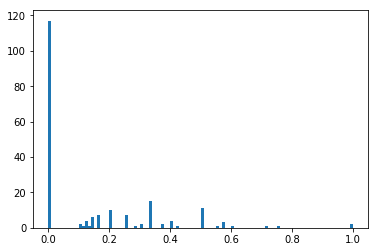

In [28]:
plt.hist(recalls_test2, bins=100)
plt.show()

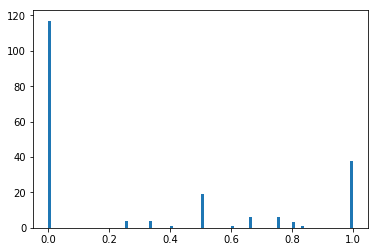

In [29]:
plt.hist(precisions_test2, bins=100)
plt.show()

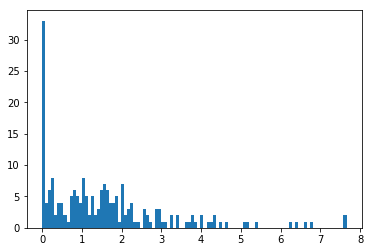

In [30]:
plt.hist(cls_losses_test2, bins=100)
plt.show()

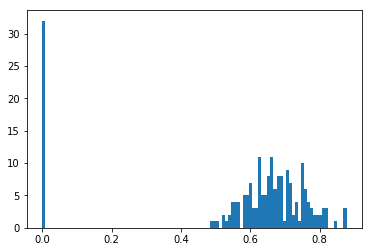

In [31]:
plt.hist(ious_test2, bins=100)
plt.show()

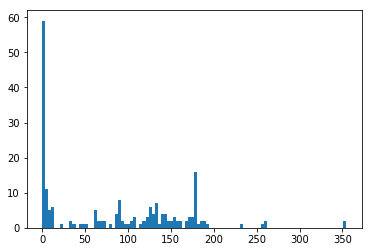

In [32]:
plt.hist(theta_diffs_test2, bins=100)
plt.show()

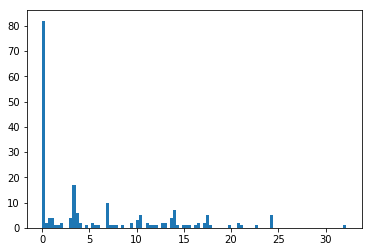

In [33]:
plt.hist(theta_losses_test2, bins=100)
plt.show()